# Model Evaluation: Random Forest
- Evaluation of Hyperparameter Tuning Results.
- For a detailed explanation of model selection, hyperparameter tuning, and evaluation metrics, please refer to the [README.md](./README.md).


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pickle
import joblib

from sklearn.metrics import classification_report

import utils.plotting_evaluation as plot_eval
import utils.model_evaluation as model_eval

import pipelines.define_pipelines_random_forest as pipeline_def
import pipelines.custom_pipeline_components as pipeline_comp



In [2]:
# Definitions
features = ['Pregnancies', 'Glucose', 'BP', 'Skin', 'Insulin', 'BMI', 'DPF', 'Age']
scoring_metrics_grid = ['accuracy', 'f1', 'roc_auc']  # scoring metrics used in the hyperparameter tuning (currently not using precision and recall)
grid_results_path = "../results/grid_search_results_random_forest"  # path to directory with results of grid search
pipeline_dict = pipeline_def.define_pipelines()  # dict of pipelines used in the hyperparameter search
n_splits = 10  # number of folds for cross-validation in hyperparameter tuning



                        Best Model for Pipeline: KNN PCA
Best hyperparameters saved to ../src/models/best_params/knn_pca_best_params_random_forest.pkl


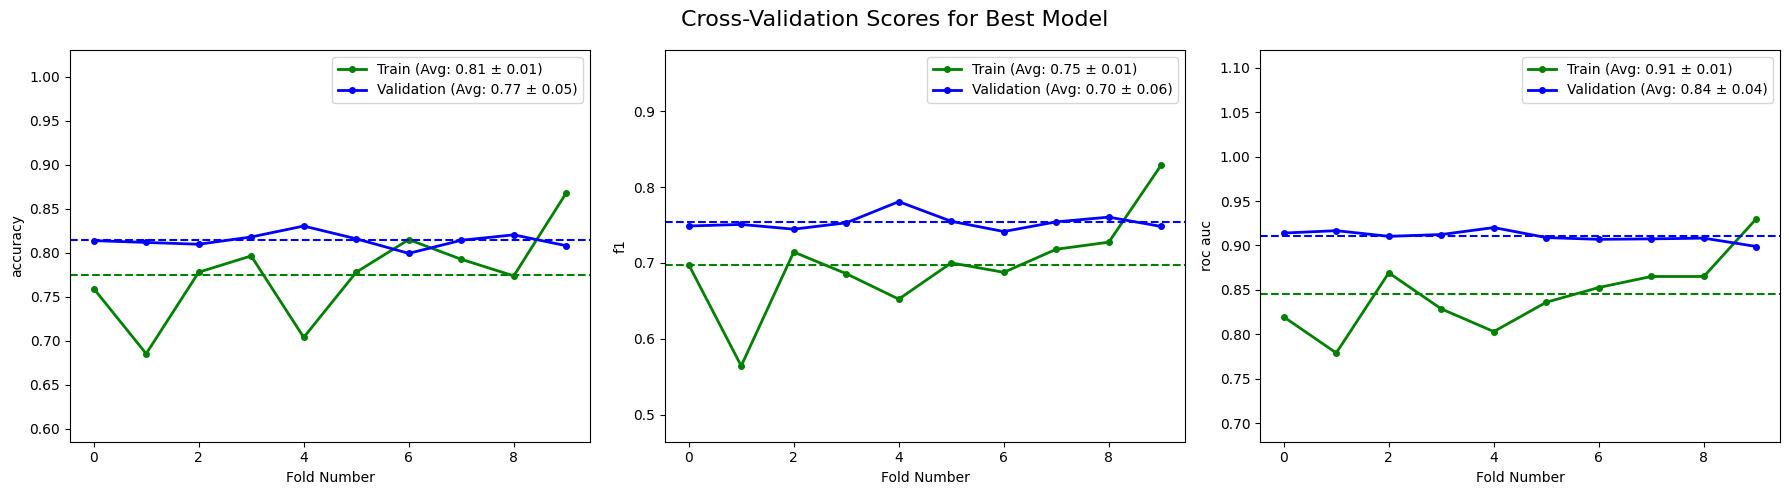


                        Best Model for Pipeline: KNN
[Scoring metric: f1] No models met the train - val diff < 0.05 and std val < 0.05 criteria. Selecting no model for this metric.
Best hyperparameters saved to ../src/models/best_params/knn_best_params_random_forest.pkl


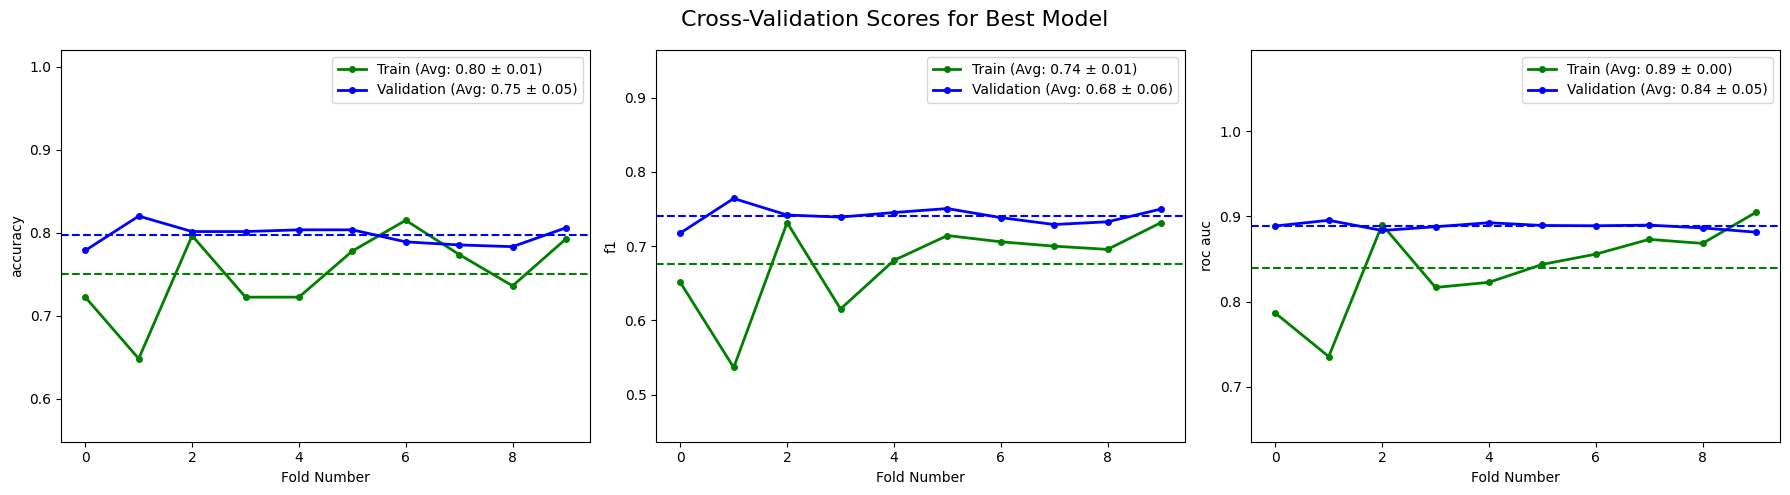


                        Best Model for Pipeline: MEAN
Best hyperparameters saved to ../src/models/best_params/mean_best_params_random_forest.pkl


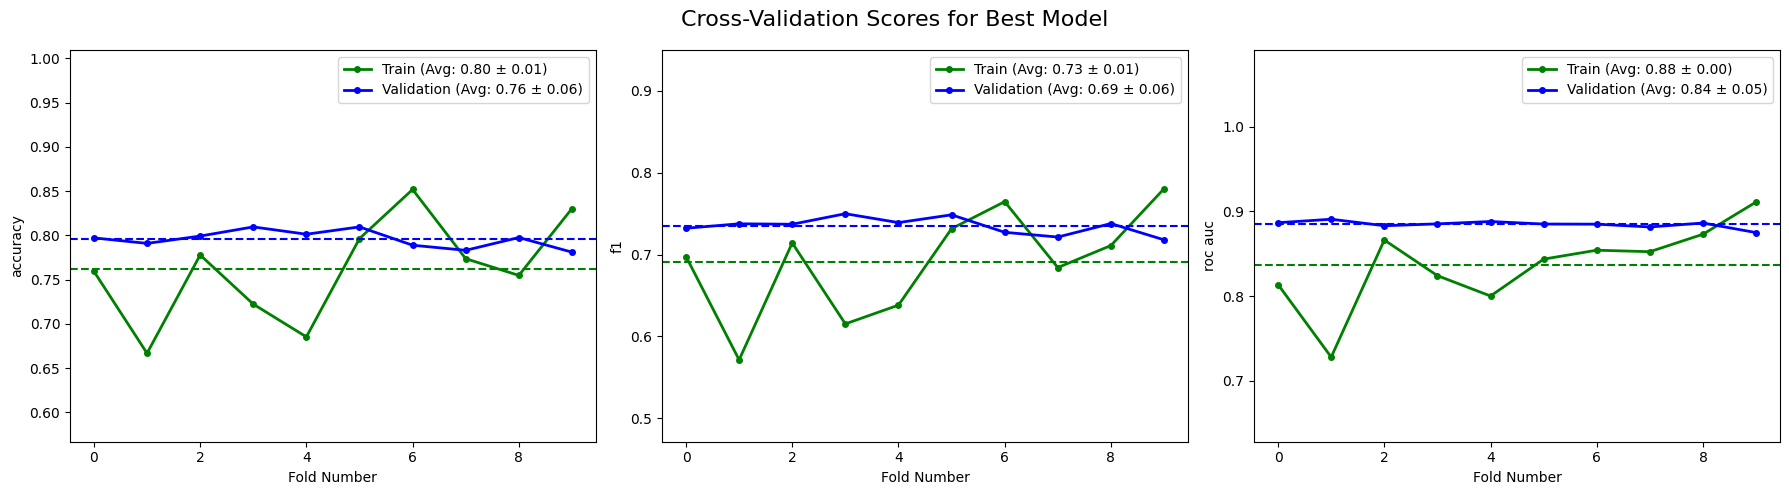


                        Best Model for Pipeline: MEDIAN
Best hyperparameters saved to ../src/models/best_params/median_best_params_random_forest.pkl


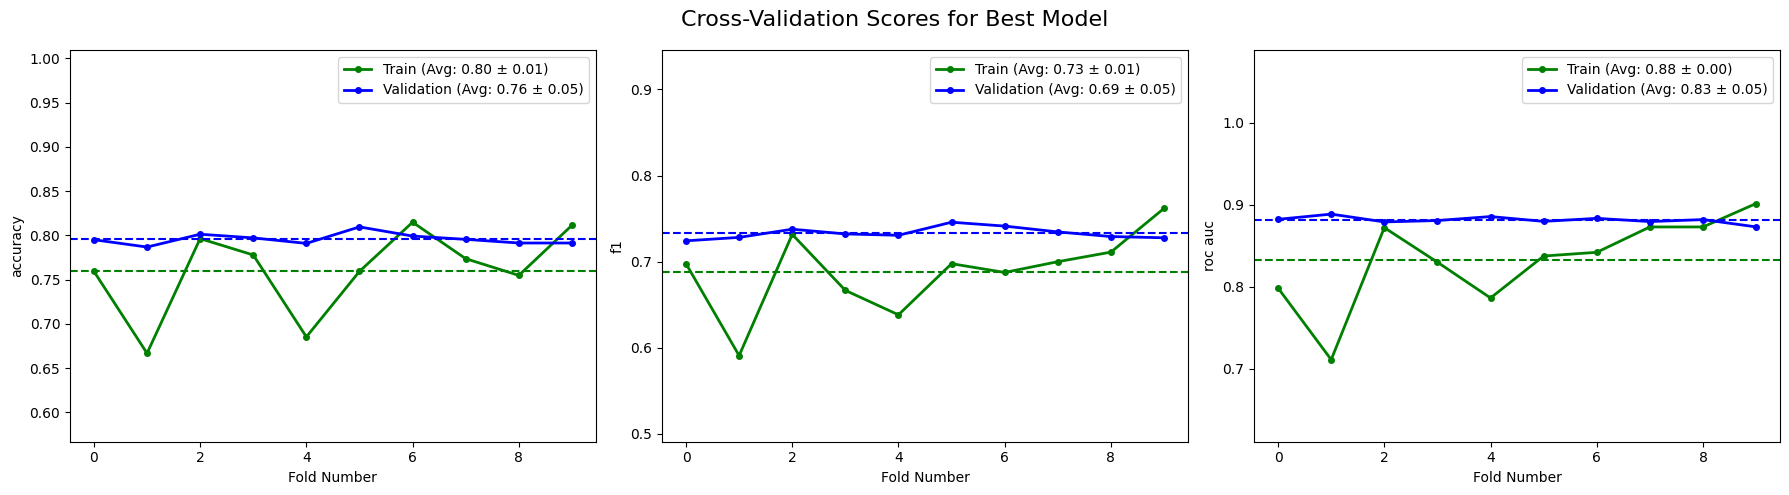


                        Best Model for Pipeline: NO IMPUTER NO KMEANS
[Scoring metric: f1] No models met the train - val diff < 0.05 and std val < 0.05 criteria. Selecting no model for this metric.
[Scoring metric: roc_auc] No models met the train - val diff < 0.05 and std val < 0.05 criteria. Selecting no model for this metric.
Best hyperparameters saved to ../src/models/best_params/no_imputer_no_kmeans_best_params_random_forest.pkl


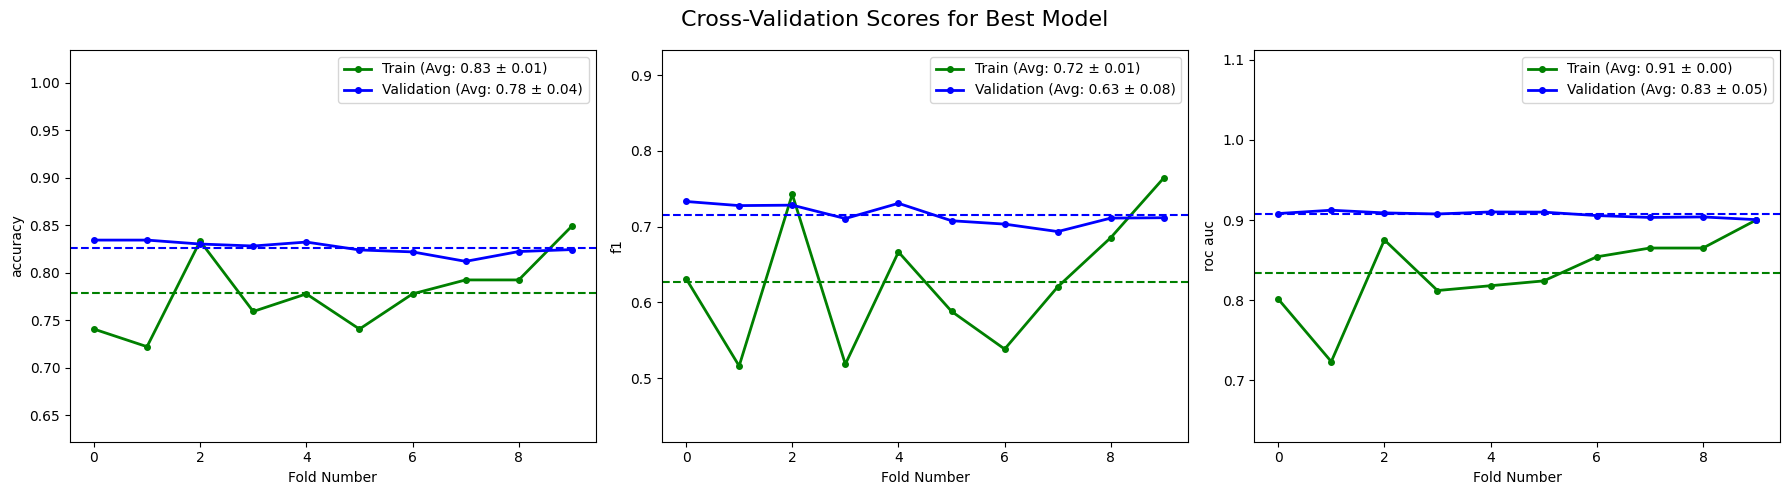


                        Best Model for Pipeline: KNN PCA NO KMEANS
[Scoring metric: f1] No models met the train - val diff < 0.05 and std val < 0.05 criteria. Selecting no model for this metric.
Best hyperparameters saved to ../src/models/best_params/knn_pca_no_kmeans_best_params_random_forest.pkl


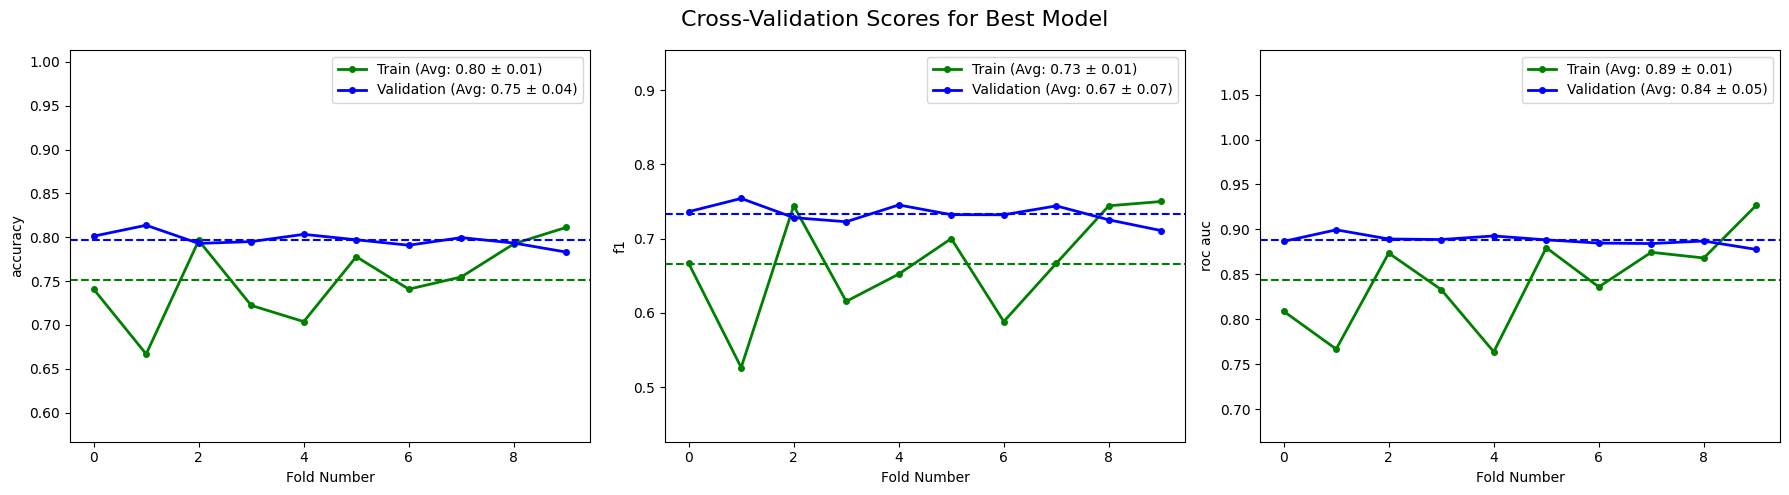


                        Best Model for Pipeline: KNN NO KMEANS
Best hyperparameters saved to ../src/models/best_params/knn_no_kmeans_best_params_random_forest.pkl


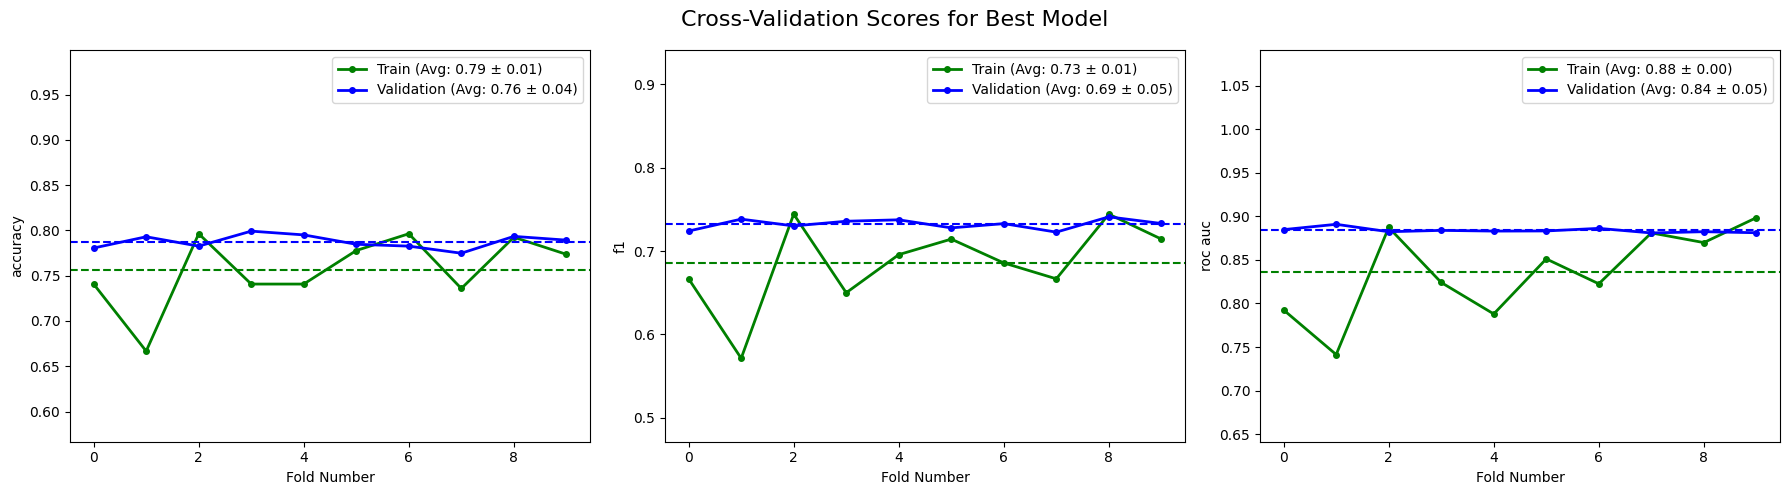


                        Best Model for Pipeline: MEAN NO KMEANS
[Scoring metric: f1] No models met the train - val diff < 0.05 and std val < 0.05 criteria. Selecting no model for this metric.
Best hyperparameters saved to ../src/models/best_params/mean_no_kmeans_best_params_random_forest.pkl


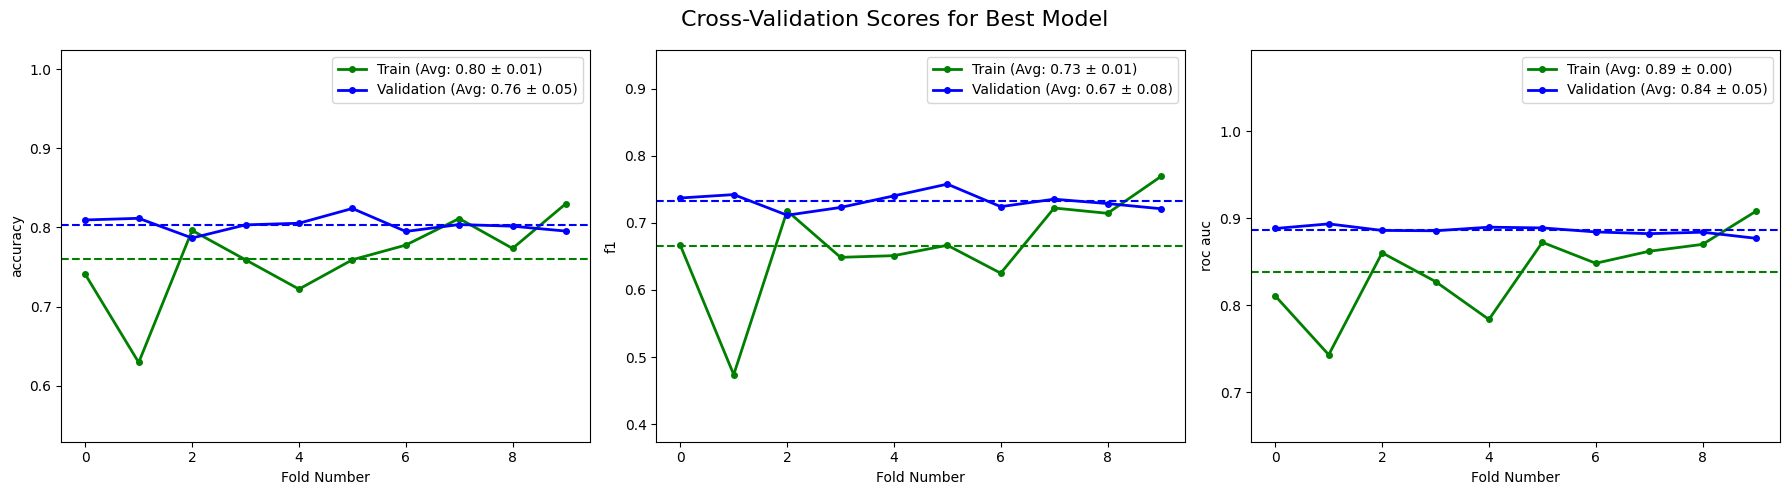


                        Best Model for Pipeline: MEDIAN NO KMEANS
[Scoring metric: f1] No models met the train - val diff < 0.05 and std val < 0.05 criteria. Selecting no model for this metric.
Best hyperparameters saved to ../src/models/best_params/median_no_kmeans_best_params_random_forest.pkl


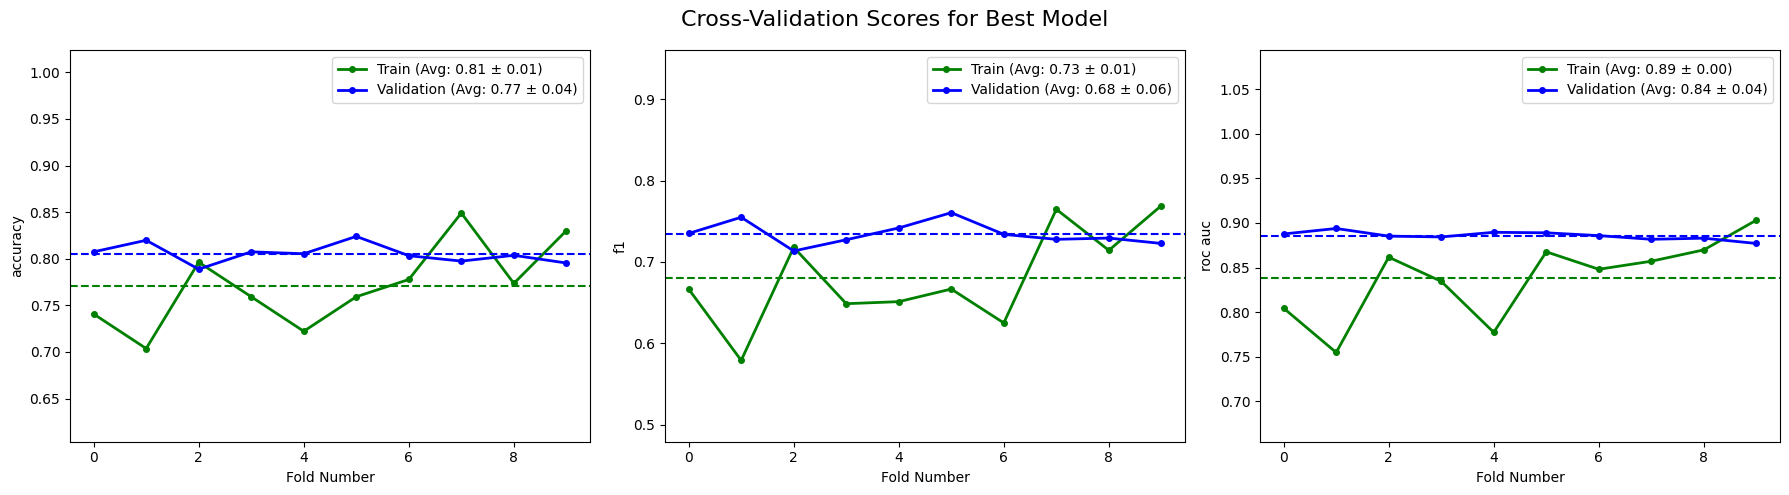

In [3]:
columns = [f"{stat}_{metric}" for metric in scoring_metrics_grid for stat in ['mean_train', 'mean_test', 'std_train', 'std_test']]
best_models_df = pd.DataFrame(columns = columns + ["pipeline_name"])

for pipeline_name, pipeline in pipeline_dict.items():
    
    print("\n" + "=" * 100)
    print(f"                        Best Model for Pipeline: {pipeline_name.replace('_',' ').upper()}")
    print("=" * 100)
    
    try:
        # Determine the best model and the best hyperparameters for the current pipeline
        best_params, best_model_scores = model_eval.determine_best_model(pipeline_name, grid_results_path, scoring_metrics_grid,
                                                                        score_diff_threshold = 0.05, std_test_threshold = 0.05,
                                                                        printing = False) # prining = True gives add info
        
        # If None is returned (no model found), skip this pipeline
        if best_params is None or best_model_scores is None:
            print(f"[Warning] No model found for pipeline {pipeline_name}. Skipping pipeline.")
            continue  # Skip the rest of the loop and move on to the next pipeline
        
        # Save the best hyperparameters
        model_eval.save_best_params(best_params, pipeline_name, classifier_type = "random_forest")
        
        # Plot the Cross-Validation scores for the best model
        plot_eval.plot_cv_scores_for_best_model(best_model_scores, scoring_metrics_grid, n_splits)
        
        # Update the pipeline with the best parameters
        pipeline.set_params(**best_params)
        
        # Add the results to the DataFrame
        new_row = best_model_scores[columns].tolist() + [pipeline_name.replace('_',' ').upper()]
        best_models_df.loc[len(best_models_df)] = new_row
        
    except Exception as e:
        # Handle errors that occur during processing
        print(f"[Error] Error processing pipeline {pipeline_name}: {e}")
        continue  # Skip the pipeline in case of an error

In [4]:
for metric in scoring_metrics_grid:
    best_models_df[f"diff_train_test_{metric}"] = best_models_df[f"mean_train_{metric}"] - best_models_df[f"mean_test_{metric}"]
mean_test_score_cols = [f"mean_test_{metric}" for metric in scoring_metrics_grid ]
std_test_score_cols = [f"std_test_{metric}" for metric in scoring_metrics_grid ]
diff_score_cols = [f"diff_train_test_{metric}" for metric in scoring_metrics_grid ]

best_models_df[["pipeline_name"] + mean_test_score_cols + std_test_score_cols + diff_score_cols ].round(4)

,pipeline_name,mean_test_accuracy,mean_test_f1,mean_test_roc_auc,std_test_accuracy,std_test_f1,std_test_roc_auc,diff_train_test_accuracy,diff_train_test_f1,diff_train_test_roc_auc
0,KNN PCA,0.7749,0.6976,0.8448,0.0494,0.0625,0.0398,0.0391,0.0560,0.0656
1,KNN,0.7506,0.6763,0.8396,0.0473,0.0577,0.0485,0.0465,0.0646,0.0487
2,MEAN,0.7618,0.6909,0.8366,0.0556,0.0624,0.0471,0.0340,0.0440,0.0481
3,MEDIAN,0.7599,0.6883,0.8326,0.0467,0.0454,0.0527,0.0359,0.0448,0.0489
4,NO IMPUTER NO KMEANS,0.7786,0.6274,0.8338,0.0384,0.0842,0.0475,0.0478,0.0886,0.0732
5,KNN PCA NO KMEANS,0.7507,0.6654,0.8432,0.0430,0.0698,0.0493,0.0464,0.0677,0.0447
6,KNN NO KMEANS,0.7561,0.6853,0.8356,0.0380,0.0486,0.0484,0.0314,0.0469,0.0483
7,MEAN NO KMEANS,0.7600,0.6656,0.8384,0.0531,0.0762,0.0460,0.0436,0.0666,0.0474
8,MEDIAN NO KMEANS,0.7712,0.6803,0.8379,0.0429,0.0576,0.0434,0.0341,0.0543,0.0478


### Comparison of Validation Scores
- All the pipelines show similar performance when tuned with their best parameters.
- The best values for each column are marked in **bold**.

| Pipeline | Mean Val. Accuracy | Mean Val. F1 | Mean Val. ROC AUC | Std Val. Accuracy | Std Val. F1 | Std Val. ROC AUC | Diff Train-Val. Accuracy | Diff Train-Val. F1 | Diff Train-Val. ROC AUC |
|----------------------------|----------|----------|----------|----------|----------|----------|----------|----------|----------|
| KNN PCA                    |  0.7749  |**0.6976**|**0.8448**|  0.0494  |  0.0625  |**0.0398**|  0.0391  |  0.0560  |  0.0656  |
| KNN                        |  0.7506  |  0.6763  |  0.8396  |  0.0473  |  0.0577  |  0.0485  |  0.0465  |  0.0646  |  0.0487  |
| MEAN                       |  0.7618  |  0.6909  |  0.8366  |  0.0556  |  0.0624  |  0.0471  |  0.0340  |**0.0440**|  0.0481  |
| MEDIAN                     |  0.7599  |  0.6883  |  0.8326  |  0.0467  |**0.0454**|  0.0527  |  0.0359  |  0.0448  |  0.0489  |
| NO IMPUTER NO KMEANS       |**0.7786**|  0.6274  |  0.8338  |  0.0384  |  0.0842  |  0.0475  |  0.0478  |  0.0886  |  0.0732  |
| KNN PCA NO KMEANS          |  0.7507  |  0.6654  |  0.8432  |  0.0430  |  0.0698  |  0.0493  |  0.0464  |  0.0677  |**0.0447**|
| KNN NO KMEANS              |  0.7561  |  0.6853  |  0.8356  |**0.0380**|  0.0486  |  0.0484  |**0.0314**|  0.0469  |  0.0483  |
| MEAN NO KMEANS             |  0.7600  |  0.6656  |  0.8384  |  0.0531  |  0.0762  |  0.0460  |  0.0436  |  0.0666  |  0.0474  |
| MEDIAN NO KMEANS           |  0.7712  |  0.6803  |  0.8379  |  0.0429  |  0.0576  |  0.0434  |  0.0341  |  0.0543  |  0.0478  |



### Model Selection Based on Ranking
- Since all models have a similar performance ranking is applied to chose the best model.
- Each model is ranked based on:
    - **F1 Score** and **ROC AUC** from the **mean test scores**.
    - **Standard deviation** of these metrics from the **validation scores**.
    - The **difference between training and validation scores**, where a large difference may indicate overfitting.



In [8]:
# Create a copy of the DataFrame for ranking
best_models_df_ranks = best_models_df.copy()

# Define relevant metric columns
sel_test_score_cols = ['mean_test_f1', 'mean_test_roc_auc']
sel_std_test_score_cols = ['std_test_f1', 'std_test_roc_auc']
sel_diff_score_cols = ['diff_train_test_f1', 'diff_train_test_roc_auc']

# Rank mean test scores (higher is better → descending order)
for col in sel_test_score_cols:
    best_models_df_ranks[f"rank_{col}"] = best_models_df_ranks[col].round(3).rank(ascending=False, method="dense")

# Rank standard deviation scores (lower is better → ascending order)
for col in sel_std_test_score_cols:
    best_models_df_ranks[f"rank_{col}"] = best_models_df_ranks[col].round(3).rank(ascending=True, method="dense")

# Rank difference train and validation scores (lower is better → ascending order)
for col in sel_diff_score_cols:
    best_models_df_ranks[f"rank_{col}"] = best_models_df_ranks[col].round(3).rank(ascending=True, method="dense")


# Calculate the overall rank by summing individual ranks
ranked_vars = [f"rank_{col}" for col in sel_test_score_cols + sel_std_test_score_cols + sel_diff_score_cols]
best_models_df_ranks["Overall Rank"] = best_models_df_ranks[ranked_vars].sum(axis=1)

# Sort by overall rank (best model at the top)
best_models_df_ranks_sorted = best_models_df_ranks[["pipeline_name", "Overall Rank"] + ranked_vars].sort_values("Overall Rank", ascending=True)

# Display the final ranked DataFrame
best_models_df_ranks_sorted[["pipeline_name", "Overall Rank"] + ranked_vars]

,pipeline_name,Overall Rank,rank_mean_test_f1,rank_mean_test_roc_auc,rank_std_test_f1,rank_std_test_roc_auc,rank_diff_train_test_f1,rank_diff_train_test_roc_auc
0,KNN PCA,17.0,1.0,1.0,4.0,1.0,5.0,5.0
2,MEAN,19.0,2.0,5.0,4.0,4.0,1.0,3.0
8,MEDIAN NO KMEANS,21.0,5.0,4.0,3.0,2.0,4.0,3.0
6,KNN NO KMEANS,23.0,4.0,6.0,2.0,5.0,3.0,3.0
3,MEDIAN,25.0,3.0,8.0,1.0,7.0,2.0,4.0
1,KNN,28.0,6.0,3.0,3.0,6.0,6.0,4.0
7,MEAN NO KMEANS,29.0,7.0,4.0,6.0,3.0,7.0,2.0
5,KNN PCA NO KMEANS,30.0,8.0,2.0,5.0,6.0,8.0,1.0
4,NO IMPUTER NO KMEANS,42.0,9.0,7.0,7.0,4.0,9.0,6.0


Here is the corrected version of the text based on the provided table:

<div style="background-color: orange; padding: 10px; color: black;">
  <p><strong>Key Observations</strong></p>

- **Highest F1 Score** → KNN PCA (0.6976) and MEAN (0.6909).
- **Highest ROC AUC** → KNN PCA (0.8448) and KNN PCA No K-Means (0.8432).
- **Best Balance Between F1 and ROC AUC** → KNN PCA (F1 = 0.6976, ROC AUC = 0.8448).
- **Stability (Best Balance Between Standard Deviation of F1 and ROC AUC)** → KNN PCA (0.0625, 0.0398) and KNN NO KMEANS (0.0486, 0.0484).
- **Generalization (Best Balance Between Diff Train - Val Data)** → MEAN (F1 = 0.0440, ROC AUC = 0.0481) followed by KNN PCA and MEDIAN NO KMEANS.

  → Choose the pipeline <strong>KNN PCA</strong> as the best model for now since it shows the overall best performance.
</div>

#### Fit best pipeline

In [9]:
# Load data
data_train = pd.read_csv("../data/preprocessed_diabetes_train.csv")
# Define features (with original name) and target
features_org = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
                'DiabetesPedigreeFunction', 'Age']

target = "Outcome"

X_train, y_train = data_train[features_org], data_train[target]


In [10]:
with open("../src/models/best_params/knn_pca_best_params_random_forest.pkl", "rb") as f:
    best_params = pickle.load(f)

best_pipeline = pipeline_dict["knn_pca"]
best_pipeline.set_params(**best_params)
best_pipeline.fit(X_train, y_train)
display(best_pipeline)

Pipeline(steps=[('rename', RenameFeatures()),
                ('preprocess',
                 PreprocessFeatures(features_no_measurements=['Glucose', 'BP',
                                                              'Skin', 'Insulin',
                                                              'BMI'])),
                ('scaler', StandardScaler()),
                ('imputer',
                 KNNImputationByGroup(columns=['Pregnancies', 'Glucose', 'BP',
                                               'Skin', 'Insulin', 'BMI', 'DPF',
                                               'Age'],
                                      n_neighbors=10)),
                ('add_kmeans',
                 AddKMeansClusterFeatures(features=['Pregnancies', 'Glucose',
                                                    'BP', 'Skin', 'Insulin',
                                                    'BMI', 'DPF', 'Age'])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=4,
                                        max_samples=0.7, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators=80,
                                        random_state=42))])

In [11]:
# Save the best pipeline to a file
joblib.dump(best_pipeline, '../src/models/best_random_forest_pipeline.pkl')

['../src/models/best_random_forest_pipeline.pkl']

### Feature Importance

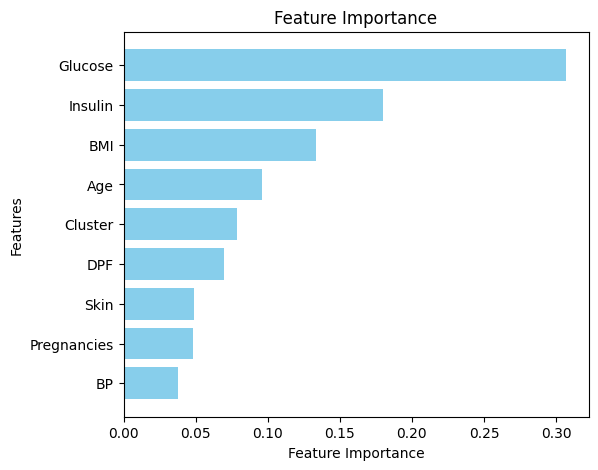

In [12]:
plot_eval.plot_best_model_feature_importance( best_pipeline,X_train, y_train, features) 

#### Shap values for predicting class 1 (Diabetic)

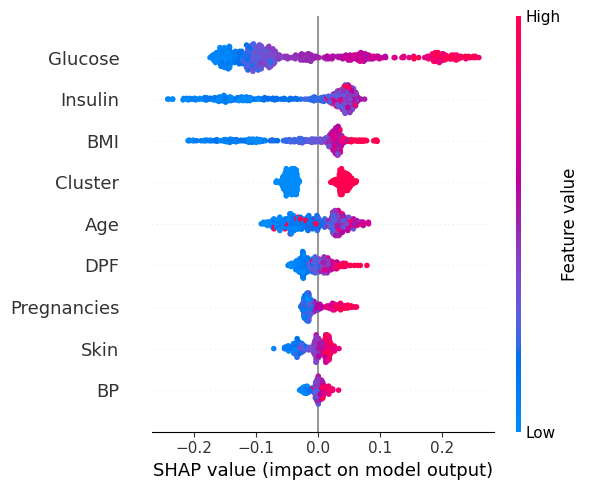

In [13]:
plot_eval.plot_shap_values_for_class_1(best_pipeline, X_train, y_train, features) # pos shap value means more likly to predict class "Diabetic"

### Discussion of Features

**Most Important Features**

- Glucose: High glucose values significantly influence the prediction, increasing the likelihood of being classified as "Diabetic."
- Insulin: Low insulin levels are the most impactful feature for predicting the "Not Diabetic" class.
- BMI (Body Mass Index): High BMI values tend to push the prediction towards the "Diabetic" class.
- Cluster Variable: The clustering feature (derived from KMeans clustering, n=2) plays a significant role in differentiating between the two classes. High cluster values tend to be associated with the "Diabetic" class, while lower values are more commonly linked to the "Not Diabetic" class.
- Age: Age is an important feature contributing to the likelihood of being diabetic. The middle range of age has the highest impact on predicting diabetes, with high age values contributing to a slightly lower likelihood of diabetes.

### Learning Curve
- Determined using the same cross-fold validation data as in hyperparameter search to prevent data leakage.
- **Training Score**: Decreases (or plateaus), indicating the model is not overfitting and is learning to generalize.
- **Validation Score**: Increases, showing the model is improving at predicting unseen data.
- **Standard Deviation of Validation Scores**: Decreases, suggesting the model is becoming more stable and less sensitive to specific data subsets.

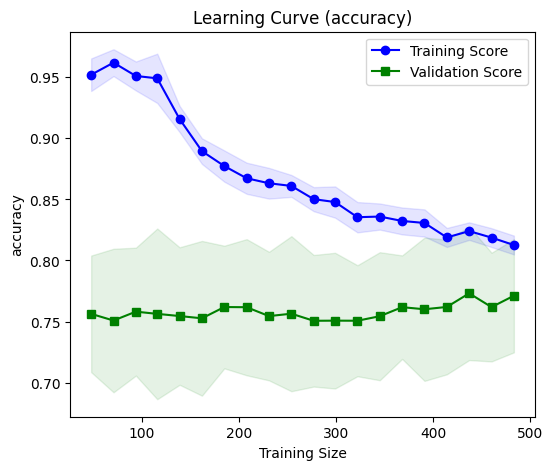

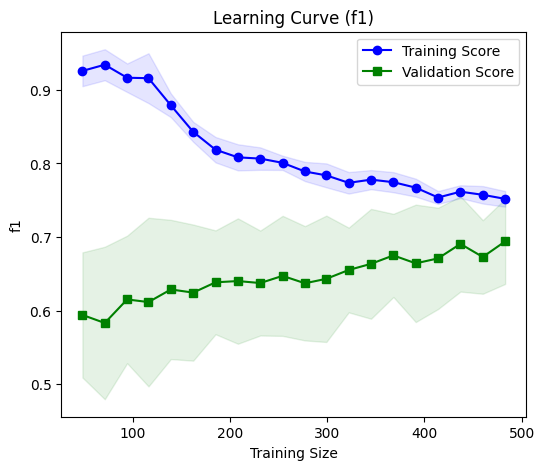

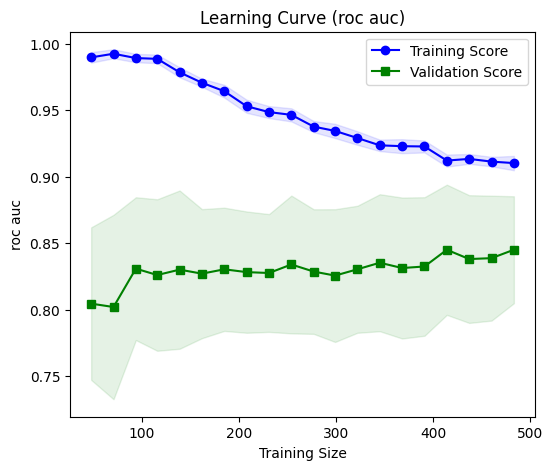

In [14]:
for metric in scoring_metrics_grid:
    plot_eval.plot_learning_curve(best_pipeline, X_train, y_train, scoring_metric= metric)

### Discussion of Learning Curve
Training Data: The total data set consists of 537 patients, and with 10-fold cross-validation, the maximum training size per fold is 483.

##### 1. Training Behavior: 
   - As more data is added, Accuracy, F1 Score, and AUC-ROC of the training scores decrease, suggesting the model is improving its ability to generalize.

##### 2. Validation Performance:
   - Accuracy, and AUC-ROC of the validation set initially improve and then plateau indicating the model reaches a point of diminishing returns, where additional data no longer significantly boosts performance. F1 Score steadily increases from 0.59 to 0.69, showing continuous improvement. The growth slows down towards the end, indicating that the model is approaching a plateau.

##### 3. Model Stability:
   - The decreasing standard deviation of validation scores for small training sizes indicates that the model is becoming more stable, with less variability in performance across different validation splits. 